In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Data creation parameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create data
X_blob, y_blob = make_blobs(n_samples = 1000, n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)

# Turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


In [2]:
# Check type
type(X_blob)

torch.Tensor

In [3]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape

torch.Size([800, 2])

Text(0.5, 1.0, 'Training Data')

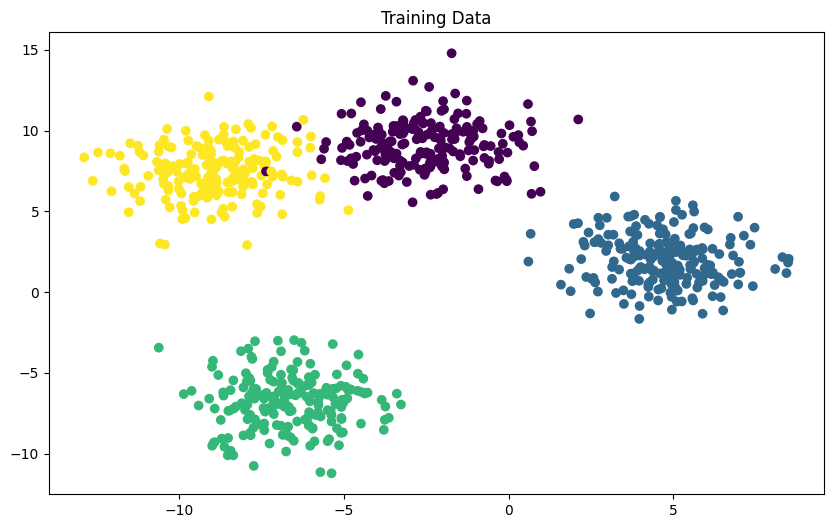

In [4]:
# Visualize data
plt.figure(figsize=(10,6))
plt.scatter(x=X_train[:,0],
            y=X_train[:,1],
            c=y_train)
plt.title('Training Data')

In [5]:
# Build Model
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)


# Create model instance
model_4 = BlobModel(input_features=2,output_features=4)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
# Create loss function & optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr=0.1)

In [7]:
# Training and Testing Loop

torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):

  # Training
  model_4.train()

  # Forward pass
  y_logits = model_4(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate loss
  loss = loss_fn(y_logits,y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_test)

    test_loss = loss_fn(test_logits,y_test)


  if epoch % 10==0:
    print(f"Epoch:{epoch}| Loss:{loss:.4f}| Test Loss:{test_loss:.4f}")



Epoch:0| Loss:2.1293| Test Loss:1.2090
Epoch:10| Loss:0.5234| Test Loss:0.4542
Epoch:20| Loss:0.1827| Test Loss:0.1627
Epoch:30| Loss:0.1036| Test Loss:0.0896
Epoch:40| Loss:0.0699| Test Loss:0.0628
Epoch:50| Loss:0.0558| Test Loss:0.0491
Epoch:60| Loss:0.0478| Test Loss:0.0408
Epoch:70| Loss:0.0427| Test Loss:0.0355
Epoch:80| Loss:0.0392| Test Loss:0.0317
Epoch:90| Loss:0.0367| Test Loss:0.0289
Epoch:100| Loss:0.0348| Test Loss:0.0268
Epoch:110| Loss:0.0334| Test Loss:0.0252
Epoch:120| Loss:0.0323| Test Loss:0.0238
Epoch:130| Loss:0.0313| Test Loss:0.0228
Epoch:140| Loss:0.0306| Test Loss:0.0218
Epoch:150| Loss:0.0300| Test Loss:0.0211
Epoch:160| Loss:0.0294| Test Loss:0.0204
Epoch:170| Loss:0.0290| Test Loss:0.0198
Epoch:180| Loss:0.0286| Test Loss:0.0193
Epoch:190| Loss:0.0282| Test Loss:0.0189
Epoch:200| Loss:0.0279| Test Loss:0.0185
Epoch:210| Loss:0.0277| Test Loss:0.0181
Epoch:220| Loss:0.0274| Test Loss:0.0178
Epoch:230| Loss:0.0272| Test Loss:0.0175
Epoch:240| Loss:0.0270| Tes

In [9]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


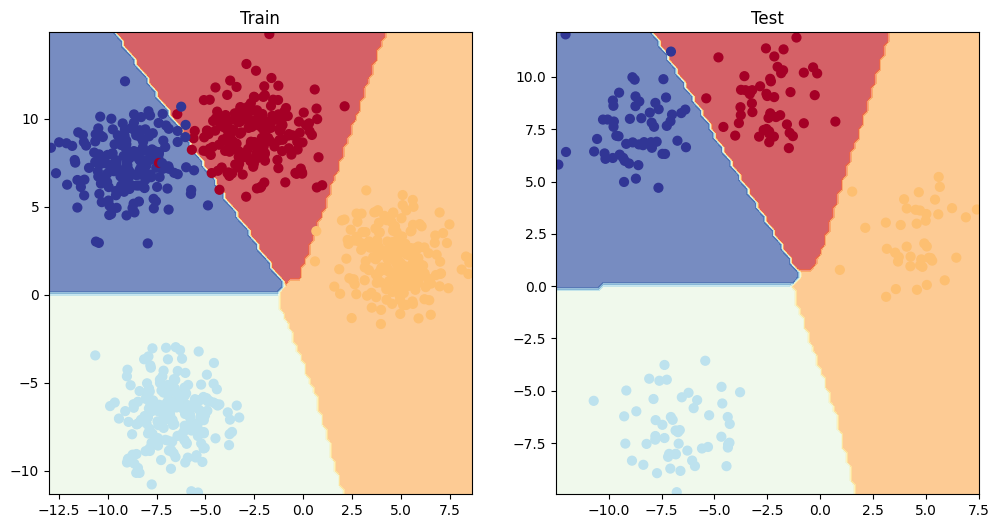

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_test,y_test)